# TODO: 
    incorporate 'quantum' effects of the system.
    test nonlinear effects by comparing to known calculations.

# First, let's compare the results from the linear and nonlinear time simulations given zero nonlinear coefficient.

Currently, Time_Sim_nonlin.py simulates a nonlinear system using purely classical dynamics. Quantum effects will be incorporated in future versions. This is done by using a non-Hermitian Hamiltonian approach. We simulate both quadrants, even though they will yield equivalent results. The derivation of the 'classical' equations of motion from the fully quantum open system model is describeds in detail in: http://aleph.physik.uni-kl.de/~korsch/papers/JPhysA_43_075306.pdf

More explicitly, we use the $-i*A$ as the equivalent linear non-Hermitian matrix for the $a$ quadrature c-number. We add the nonlinear interaction terms to this Hamiltonian. The non-Hermitian Hamiltonian equations of motion are

$$
\frac{d a}{dt}
= i \frac{\partial H}{\partial a^*} \hspace{1in}
\frac{d a^*}{dt}
=- i \frac{\partial H^*}{\partial a}.
$$

Notice we will NOT observe squeezing because the simulation is purely classical. The two quadrants are related by a complex conjugate. In future tests, we will compute the squeezing spectrum for examples in Milburn's book to see if they match our computer model.

## Testing

The simplest test is to compare to the linear system in the case when we set the nonlinear coefficient to zero. We do this below.

In [1]:
from sympy.physics.quantum import *
from sympy.physics.quantum.boson import *
from sympy.physics.quantum.operatorordering import *

In [2]:
import Potapov_Code.Roots as Roots
import Potapov_Code.Potapov as Potapov
import Potapov_Code.Time_Delay_Network as Time_Delay_Network
import Potapov_Code.Time_Sims_nonlin as Time_Sims_nonlin
import Potapov_Code.functions as functions
import Potapov_Code.tests as tests
import Potapov_Code.Hamiltonian as Hamiltonian

import pickle
import numpy as np
import sympy as sp
import numpy.linalg as la
from scipy.integrate import ode
import scipy.constants as consts

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sympy import init_printing
init_printing() 

# Let's try a very simple example: 

In [4]:
i = 0 ## port

In [38]:
displaced_freq =  5e14

In [39]:
## Make base system

Ex = Time_Delay_Network.Example1(max_freq=15.,center_freq = 0.)
Ex.run_Potapov()
modes = functions.spatial_modes(Ex.roots,Ex.M1,Ex.E,Ex.delays)
M = len(Ex.roots)

In [40]:
Ex.roots = map(lambda z: z + 1j *(displaced_freq ),Ex.roots)  ## <-- visible frequency ~ 500 THz

In [41]:
Ex.roots

[(-0.74381183771403225+500000000000000j)]

In [42]:
A_d,B_d,C_d,D_d = Ex.get_Potapov_ABCD(doubled=True)
A,B,C,D = Ex.get_Potapov_ABCD(doubled=False)

In [43]:
ham = Hamiltonian.Hamiltonian(Ex.roots,modes,Ex.delays,Omega=-1j*A,)

In [44]:
ham.nonlin_coeff= 1.

In [45]:
ham.chi_nonlinearities = []
ham.make_chi_nonlinearity(delay_indices=[0],start_nonlin=0,
                           length_nonlin=0.1*consts.c,chi_order=3)
H = ham.make_H()

In [46]:
print (normal_order(H.expand()))

500000000000000.0*Dagger(a_0)*a_0 + 0.743811837714032*I*Dagger(a_0)*a_0 + 4.77145440655697e-26*Dagger(a_0)*a_0**3 + 2.00444329646334e-26*I*Dagger(a_0)*a_0**3 + 7.15718160983545e-26*Dagger(a_0)**2*a_0**2 + 4.77145440655697e-26*Dagger(a_0)**3*a_0 - 2.00444329646334e-26*I*Dagger(a_0)**3*a_0 + 1.19286360163924e-26*Dagger(a_0)**4 - 1.00222164823167e-26*I*Dagger(a_0)**4 + 1.19286360163924e-26*a_0**4 + 1.00222164823167e-26*I*a_0**4


In [47]:
Ex.roots = map(lambda z: z - 1j *(displaced_freq  ),Ex.roots)  ## <-- visible frequency ~ 500 THz

For the Kerr model, we can get detuning by just shifting the frequencies, recomputing the A matrix, and using that
to reconstruct the linear Hamiltonian. More generally, we will need to rotate $a \to a e^{-i \Delta t},a^* \to a e^{i \Delta t}$ for detuning $\Delta$. This will be implemented in Potapov_Code.Hamiltonian in the future.

Alternatively, we could modify the inputs $I \to I  e^{-i \Delta t}, I^* = I^* e^{i \Delta t}$.

In [48]:
detuning = 10.

In [49]:
Ex.roots = map(lambda z: z - 1j *(detuning  ),Ex.roots)  ## <-- visible frequency ~ 500 THz

In [50]:
Ex.roots

[(-0.74381183771403225-10j)]

In [51]:

A_d,B_d,C_d,D_d = Ex.get_Potapov_ABCD(doubled=True)
A,B,C,D = Ex.get_Potapov_ABCD(doubled=False)

In [52]:
ham.Omega = -1j*A

In [53]:
H = ham.make_H()

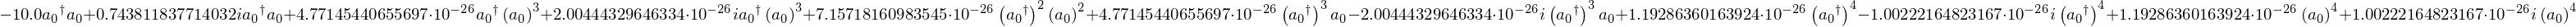

In [54]:
(normal_order(H.expand())).expand()

In [55]:
## Right now, the frequency-matching part is still under construction.
## I am adding this part by hand for now.

ham.H += 200*ham.Dagger(ham.a[0])**2*(ham.a[0])**2

In [56]:
print (normal_order((ham.H).expand())).expand()

-10.0*Dagger(a_0)*a_0 + 0.743811837714032*I*Dagger(a_0)*a_0 + 4.77145440655697e-26*Dagger(a_0)*a_0**3 + 2.00444329646334e-26*I*Dagger(a_0)*a_0**3 + 200.0*Dagger(a_0)**2*a_0**2 + 4.77145440655697e-26*Dagger(a_0)**3*a_0 - 2.00444329646334e-26*I*Dagger(a_0)**3*a_0 + 1.19286360163924e-26*Dagger(a_0)**4 - 1.00222164823167e-26*I*Dagger(a_0)**4 + 1.19286360163924e-26*a_0**4 + 1.00222164823167e-26*I*a_0**4


In [57]:
## Equations of motion and initial conditions

In [58]:
eq_mot = ham.make_eq_motion()
y0 = np.asmatrix([0.]*2*M).T

In [59]:
## constant inputs, different input amplitudes.

In [60]:
a_in_const = {}
f_const = {}
f_const_lin = {}

input_amplitudes = [1e-1,3e-1,6e-1,1.]
for amp in input_amplitudes:
    a_in_const[amp] = lambda t: np.asmatrix([amp]*np.shape(D_d)[-1]).T  ## make a sample input function
    f_const[amp] = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in_const[amp])
    f_const_lin[amp] = Time_Sims_nonlin.make_f_lin(A_d,B_d,a_in_const[amp])

In [61]:
Y_const_lin = {}
Y_const_nonlin = {}
for amp in input_amplitudes:
    Y_const_lin[amp] = Time_Sims_nonlin.run_ODE(f_const_lin[amp], a_in_const[amp], C_d, D_d, 2*M, T = 8., dt = 0.01)  ## select f here.
    Y_const_nonlin[amp] = Time_Sims_nonlin.run_ODE(f_const[amp], a_in_const[amp], C_d, D_d, 2*M, T = 8., dt = 0.01)  ## select f here.

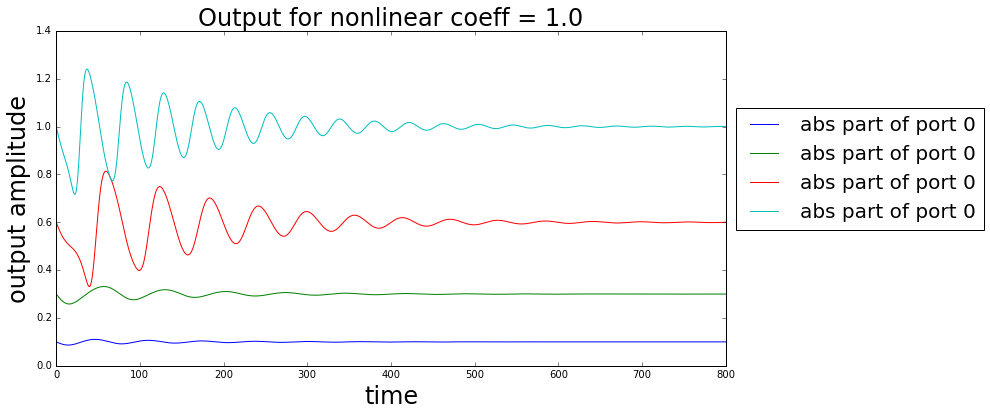

In [62]:
plt.figure(figsize=(12,6))
for amp in input_amplitudes:
    #plt.plot( [ (y[i][0,0]).real for y in Y_const_nonlin[amp]],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_const_nonlin[amp]],label = 'imaginary part of port '+str(i))
    plt.plot( [ abs(y[i][0,0]) for y in Y_const_nonlin[amp]],label = 'abs part of port '+str(i))
    #plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_const_nonlin[amp]],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(1.2, 0.8),loc='upper center',fontsize=20)

In [63]:
## linear model for comparison

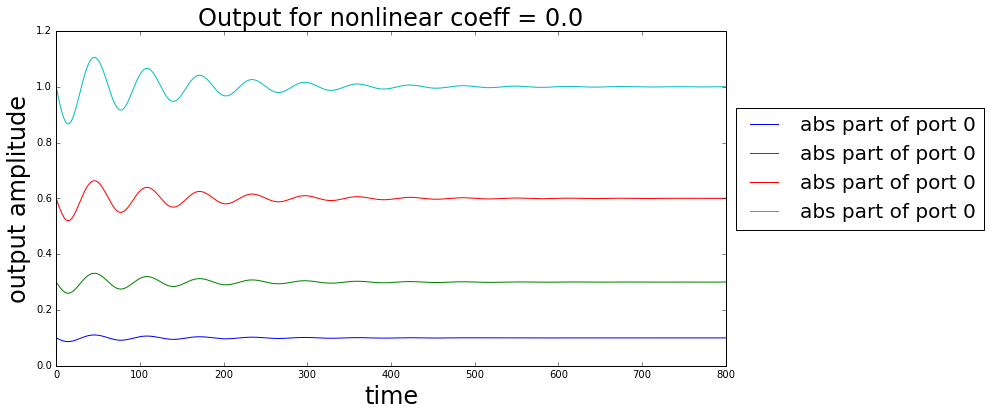

In [64]:
plt.figure(figsize=(12,6))
for amp in input_amplitudes:
    #plt.plot( [ (y[i][0,0]).real for y in Y_const_nonlin[amp]],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_const_nonlin[amp]],label = 'imaginary part of port '+str(i))
    plt.plot( [ abs(y[i][0,0]) for y in Y_const_lin[amp]],label = 'abs part of port '+str(i))
    #plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_const_nonlin[amp]],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(0.) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(1.2, 0.8),loc='upper center',fontsize=20)

In [65]:
## Ramp inputs

In [66]:
a_in = lambda t: np.asmatrix([t/300.]*np.shape(D_d)[-1]).T  ## make a sample input function
a_in_2 = lambda t: np.asmatrix([1.-t/300.]*np.shape(D_d)[-1]).T  ## make a sample input function

f = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in)
f_lin = Time_Sims_nonlin.make_f_lin(A_d,B_d,a_in)

f_2 = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in_2)
f_lin_2 = Time_Sims_nonlin.make_f_lin(A_d,B_d,a_in_2)

In [67]:
Y_lin = Time_Sims_nonlin.run_ODE(f_lin, a_in, C_d, D_d, 2*M, T = 300., dt = 0.01)  ## select f here.
Y_nonlin = Time_Sims_nonlin.run_ODE(f, a_in, C_d, D_d, 2*M, T = 300., dt = 0.01)  ## select f here.

Y_lin_2 = Time_Sims_nonlin.run_ODE(f_lin_2, a_in_2, C_d, D_d, 2*M, T = 300., dt = 0.01)  ## select f here.
Y_nonlin_2 = Time_Sims_nonlin.run_ODE(f_2, a_in_2, C_d, D_d, 2*M, T = 300., dt = 0.01)  ## select f here.

In [68]:
Y_lin_2.reverse()
Y_nonlin_2.reverse()

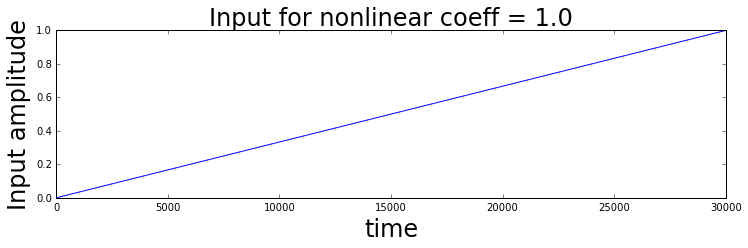

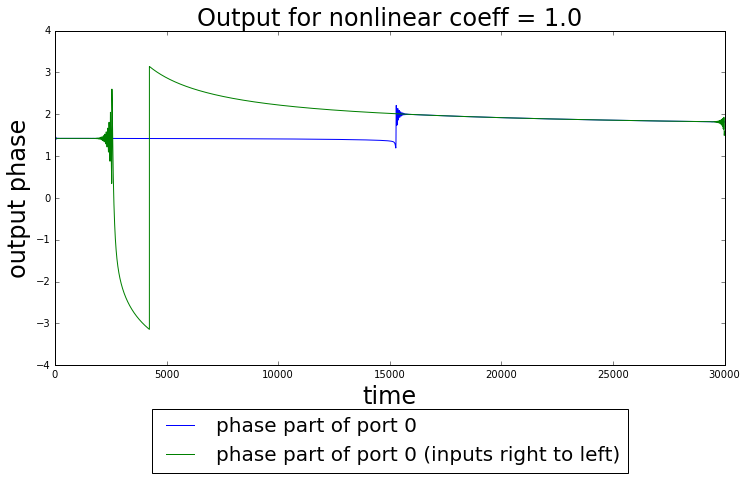

In [69]:
plt.figure(figsize=(12,3))

plt.plot( np.asarray([a_in(t)[0,0] for t in np.linspace(0,300.,30001.)]),label = 'input' )
plt.xlabel('time',{'fontsize': 24})
plt.ylabel('Input amplitude',{'fontsize': 24})
plt.title('Input for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})


plt.figure(figsize=(12,6))
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_nonlin],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_nonlin],label = 'imaginary part of port '+str(i))
    #plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin],label = 'abs part of port '+str(i))
    plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_nonlin],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output phase',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0, 1.4),loc='upper center',fontsize=20)
    
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_nonlin_2],label = 'real part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ (y[i][0,0]).imag for y in Y_nonlin_2],label = 'imaginary part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin_2],label = 'abs part of port '+str(i)+' (inputs right to left)')
    plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_nonlin_2],label = 'phase part of port '+str(i)+' (inputs right to left)')
    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output phase',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0.5, -0.1),loc='upper center',fontsize=20)

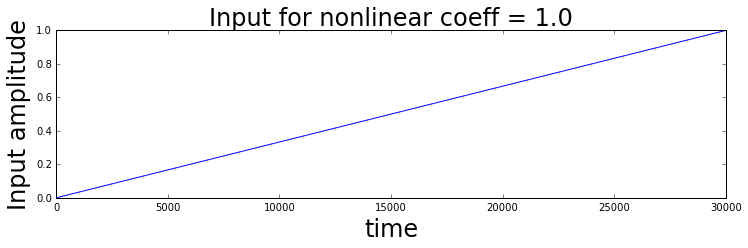

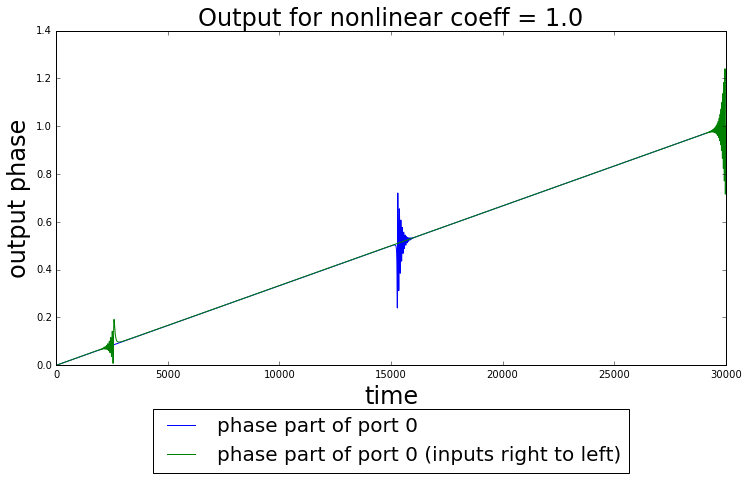

In [70]:
plt.figure(figsize=(12,3))

plt.plot( np.asarray([a_in(t)[0,0] for t in np.linspace(0,300.,30001.)]),label = 'input' )
plt.xlabel('time',{'fontsize': 24})
plt.ylabel('Input amplitude',{'fontsize': 24})
plt.title('Input for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})


plt.figure(figsize=(12,6))
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_nonlin],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_nonlin],label = 'imaginary part of port '+str(i))
    #plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin],label = 'abs part of port '+str(i))
    plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output phase',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0, 1.4),loc='upper center',fontsize=20)
    
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_nonlin_2],label = 'real part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ (y[i][0,0]).imag for y in Y_nonlin_2],label = 'imaginary part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin_2],label = 'abs part of port '+str(i)+' (inputs right to left)')
    plt.plot( [ abs((y[i][0,0])) for y in Y_nonlin_2],label = 'phase part of port '+str(i)+' (inputs right to left)')
    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output phase',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0.5, -0.1),loc='upper center',fontsize=20)

In [102]:
## Linear equations of motion for comparison

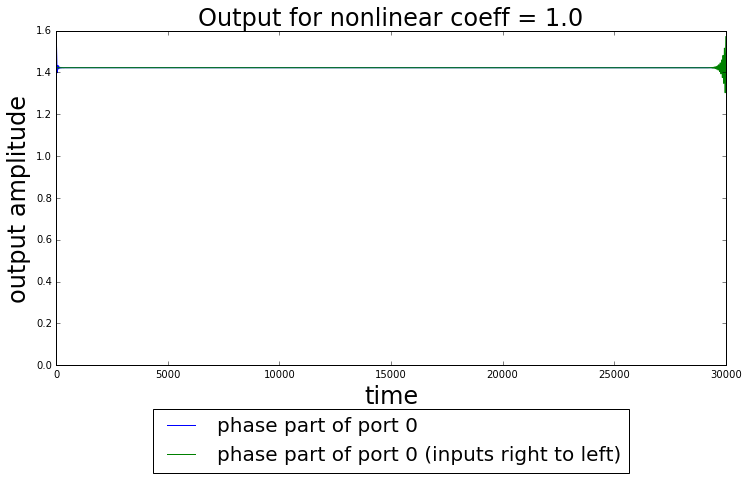

In [38]:
plt.figure(figsize=(12,6))
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_lin],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_lin],label = 'imaginary part of port '+str(i))
    #plt.plot( [ abs(y[i][0,0]) for y in Y_lin],label = 'abs part of port '+str(i))
    plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_lin],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0, 1.4),loc='upper center',fontsize=20)
    
for i in range(1):
    #plt.plot( [ (y[i][0,0]).real for y in Y_lin_2],label = 'real part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ (y[i][0,0]).imag for y in Y_lin_2],label = 'imaginary part of port '+str(i)+' (inputs right to left)')
    #plt.plot( [ abs(y[i][0,0]) for y in Y_lin_2],label = 'abs part of port '+str(i)+' (inputs right to left)')
    plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_lin_2],label = 'phase part of port '+str(i)+' (inputs right to left)')
    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(0.5, -0.1),loc='upper center',fontsize=20)

In [39]:
## constant inputs, different nonlinear coefficients

In [40]:
nonlin_coeffs_list = [0.,1e-1,3e-1,6e-1,1.]

Y_varying_coeffs = {}

for nonlin_coeff in nonlin_coeffs_list:
    ham.nonlin_coeff= nonlin_coeff
    H = ham.make_H()
    eq_mot = ham.make_eq_motion()
    y0 = np.asmatrix([0.]*2*M).T
    a_in = lambda t: np.asmatrix([1.]*np.shape(D_d)[-1]).T  ## make a sample input function
    f = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in)
    Y_varying_coeffs[nonlin_coeff] = Time_Sims_nonlin.run_ODE(f, a_in, C_d, D_d, 2*M, T = 10., dt = 0.01)  ## select f here.


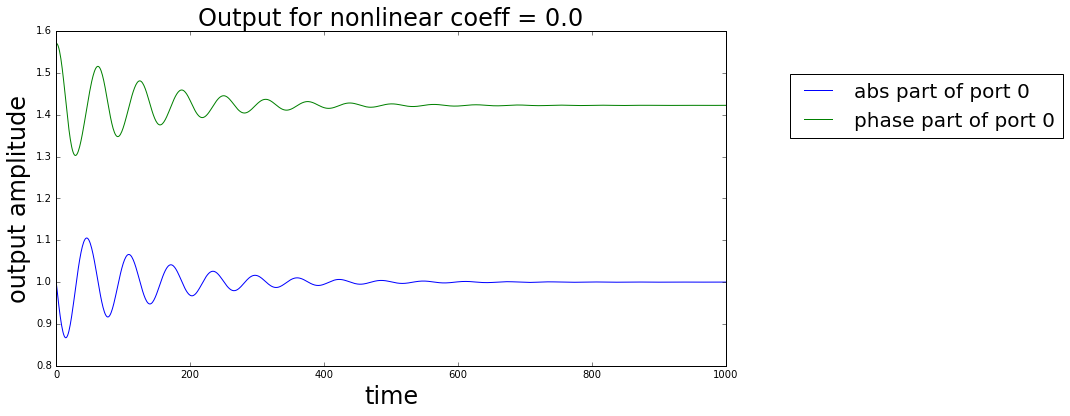

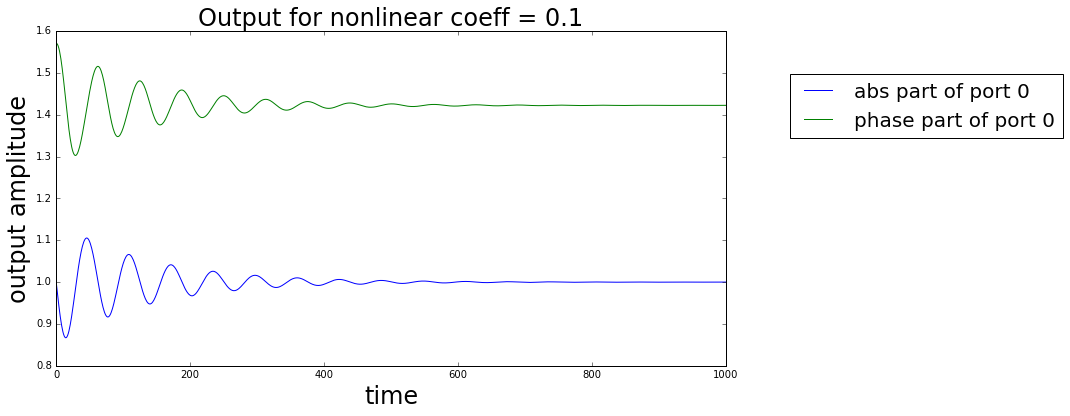

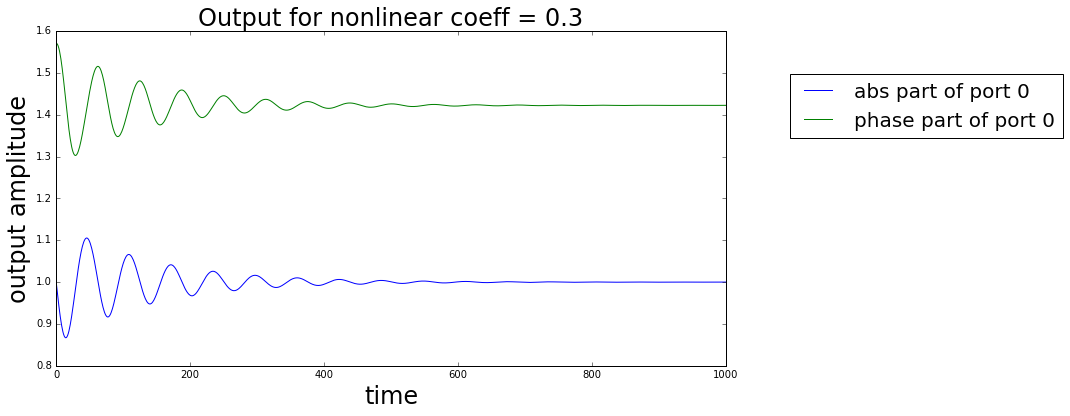

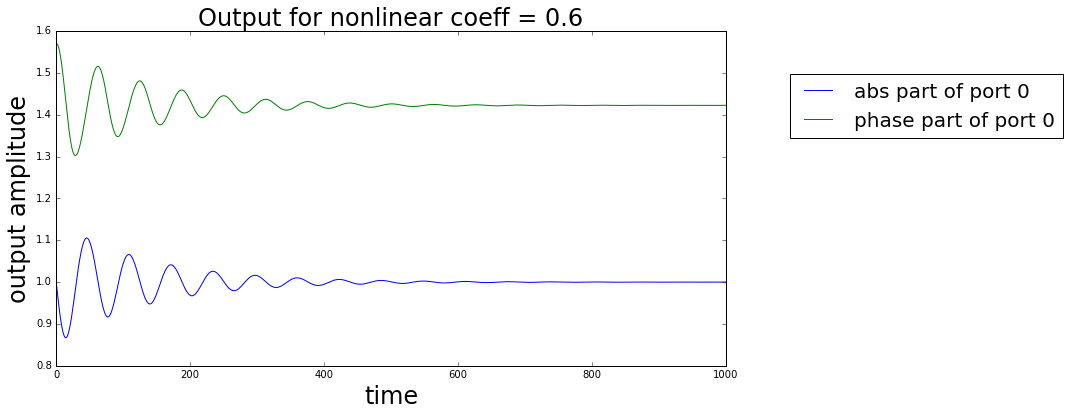

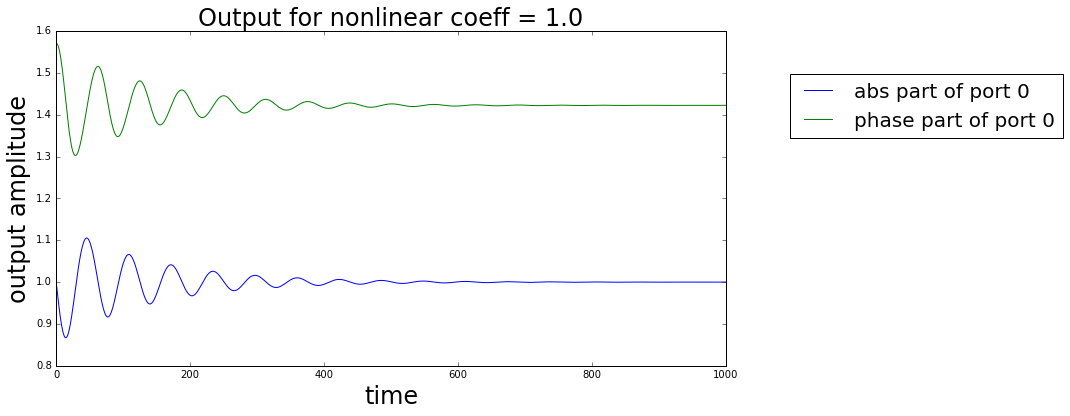

In [41]:

for nonlin_coeff in nonlin_coeffs_list:
    plt.figure(figsize=(12,6))
    #plt.plot( [ (y[i][0,0]).real for y in Y_varying_coeffs[nonlin_coeff]],label = 'real part of port '+str(i))
    #plt.plot( [ (y[i][0,0]).imag for y in Y_varying_coeffs[nonlin_coeff]],label = 'imaginary part of port '+str(i))
    plt.plot( [ abs(y[i][0,0]) for y in Y_varying_coeffs[nonlin_coeff]],label = 'abs part of port '+str(i))
    plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_varying_coeffs[nonlin_coeff]],label = 'phase part of port '+str(i))

    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(nonlin_coeff) ,{'fontsize': 24})
    plt.legend(bbox_to_anchor=(1.3, 0.9),loc='upper center',fontsize=20)

## Officially using the program to move the reference frame to rotating frame

In [42]:
displaced_freq =  5e14
i=0

In [43]:
## Make base system

Ex = Time_Delay_Network.Example1(max_freq=15.,center_freq = 20.)
Ex.run_Potapov()
modes = functions.spatial_modes(Ex.roots,Ex.M1,Ex.E,Ex.delays)
M = len(Ex.roots)

Potapov_Code/Time_Delay_Network.py:553: RuntimeWarning: overflow encountered in exp
  self.T_denom = lambda z: (1.-self.r* np.exp(-z*self.tau))


In [44]:
Ex.roots

[(-0.74381183771403225+20.943951023931955j)]

In [45]:
Ex.roots = map(lambda z: z + 1j *(displaced_freq ),Ex.roots)  ## <-- visible frequency ~ 500 THz

In [46]:
A_d,B_d,C_d,D_d = Ex.get_Potapov_ABCD(doubled=True)
A,B,C,D = Ex.get_Potapov_ABCD(doubled=False)
ham = Hamiltonian.Hamiltonian(Ex.roots,modes,Ex.delays,Omega=-1j*A)
ham.nonlin_coeff= 1.

ham.chi_nonlinearities = []
ham.make_chi_nonlinearity(delay_indices=0,start_nonlin=0,
                           length_nonlin=0.1,chi_order=3,)

H = ham.make_H()

TypeError: 'int' object is not iterable

In [ ]:
H

In [ ]:
## displace with method next:

In [ ]:
ham.move_to_rotating_frame(5e14)

In [ ]:
H = ham.H

In [ ]:
H

In [ ]:
eq_mot = ham.make_eq_motion()
y0 = np.asmatrix([0.]*2*M).T
a_in = lambda t: np.asmatrix([1.]*np.shape(D_d)[-1]).T  ## make a sample input function
f = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in)
Y_rotating_frame = Time_Sims_nonlin.run_ODE(f, a_in, C_d, D_d, 2*M, T = 10., dt = 0.01)  ## select f here.

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot( [ (y[i][0,0]).real for y in Y_rotating_frame],label = 'real part of port '+str(i))
#plt.plot( [ (y[i][0,0]).imag for y in Y_rotating_frame,label = 'imaginary part of port '+str(i))
plt.plot( [ abs(y[i][0,0]) for y in Y_rotating_frame],label = 'abs part of port '+str(i))
#plt.plot( [ np.arctan2((y[i][0,0]).real,(y[i][0,0]).imag) for y in Y_rotating_frame],label = 'phase part of port '+str(i))

plt.xlabel('time',{'fontsize': 24})
plt.ylabel('output amplitude',{'fontsize': 24})
plt.title('Output for nonlinear coeff = ' + str(ham.nonlin_coeff) ,{'fontsize': 24})
plt.legend(bbox_to_anchor=(1.3, 0.9),loc='upper center',fontsize=20)